### Web Scraping

In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
base_url="https://www.airlinequality.com/airline-reviews/british-airways"
pages=38
page_size=100
reviews=[]
for i in range (1,pages+1):
  url=f'{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}'
  response = requests.get(url)
  content = response.content
  parsed_content = BeautifulSoup(content, 'html.parser')
  paras = parsed_content.find_all('div',class_='text_content')
  for para in paras:
   reviews.append(para.get_text())
  print(f"   ---> {len(reviews)} total reviews")

   ---> 100 total reviews
   ---> 200 total reviews
   ---> 300 total reviews
   ---> 400 total reviews
   ---> 500 total reviews
   ---> 600 total reviews
   ---> 700 total reviews
   ---> 800 total reviews
   ---> 900 total reviews
   ---> 1000 total reviews
   ---> 1100 total reviews
   ---> 1200 total reviews
   ---> 1300 total reviews
   ---> 1400 total reviews
   ---> 1500 total reviews
   ---> 1600 total reviews
   ---> 1700 total reviews
   ---> 1800 total reviews
   ---> 1900 total reviews
   ---> 2000 total reviews
   ---> 2100 total reviews
   ---> 2200 total reviews
   ---> 2300 total reviews
   ---> 2400 total reviews
   ---> 2500 total reviews
   ---> 2600 total reviews
   ---> 2700 total reviews
   ---> 2800 total reviews
   ---> 2900 total reviews
   ---> 3000 total reviews
   ---> 3100 total reviews
   ---> 3200 total reviews
   ---> 3300 total reviews
   ---> 3400 total reviews
   ---> 3500 total reviews
   ---> 3600 total reviews
   ---> 3700 total reviews
   ---> 38

In [3]:
import pandas as pd
df = pd.DataFrame()
df['reviews']=reviews
df.head()

,reviews
0,✅ Trip Verified | Flight cancelled due to bad ...
1,✅ Trip Verified | British Airways oversold my...
2,✅ Trip Verified | I travelled London to Doha ...
3,✅ Trip Verified | When dropping off my luggag...
4,✅ Trip Verified | If you can’t fly First Class...


In [4]:
df_raw = df.copy()
df_raw.shape

(3800, 1)

In [5]:
df['reviews']=df['reviews'].str.split('|', expand=True)[1]
df['reviews'].head()

,reviews
0,"Flight cancelled due to bad weather, BA contacted me by email immediately and provided an alternative booking as well as a link if their suggestion for a different flight wasn't convenient. Clicked on the link and was assisted promptly by a service rep who rebooked me and sent all details within a few minutes. Great customer service from BA....well done."
1,"British Airways oversold my LHR to LAX flight; I booked months in advance paid in full and actually paid over $1000 extra to fly their Airbus A380. Tried to check in online day before flight, got unknown system error couldn’t check in. Arrived at LHR 3.5 hours early; none of BA kiosks worked, all manual check in by understaffed BA staff who were all unhelpful. Insane queue times; lots of other frustrated passengers in line. Denied boarding at the gate because flight oversold, no explanations, no apologies, constantly ignored by BA staff who don’t have the patience to listen to your situation or be helpful. Finally gate manager books alternate flight to Paris CDG, supposedly to connect with an Air France flight. We get to CDG only to be told by Air France their flight was full; no idea why BA manager bumped me to AF flight that’s also full! That’s insult to injury to be bumped twice! Went to BA desk at CDG, no help at all they told us to call BA and couldn’t even provide the phone number; just told us to look online. On top of all that my luggage is lost somewhere between BA and AF in Paris CDG. I’m an American citizen and speak perfect English, but I feel completely humiliated and treated like second class citizen by multiple BA staff through the whole ordeal. Mostly they just ignore you or bounce you from one counter to another without even trying to listen to your problem. Zero accountability. Will never ever fly BA again! Absolute worst travel experience of my life."
2,"I travelled London to Doha on July 16th, I had to physically check in at BA Business T5 because I had an ongoing connection in Doha and the flight was a code share with Qatar. I had paid for my flight through Qatar and paid for the seat online so I could sit where I like to sit and when I got to check in discovered I had been reseated elsewhere in the cabin and was told that was their policy and basically to shut up about it. I then discovered that BA do not recognise Qatar frequent flyer rules despite sharing Avios points. I'm a Gold card holder in Qatar which affords me extra kilos on the baggage but BA tried to tell me I had to pay. After some arguing eventually they accepted it! The Lounge was packed, staff less than helpful when I tried to get some answers on my seat reassignment, I was told I would get my money back - no chance of that so don't even try. The flight boarded by bus, the journey took 15 minutes to get from terminal to aircraft which I am guessing was at another terminal because it took so long to get there. Why not board us through that terminal rather than drag us all over the airport? Finally got onto the plane, BA staff are not friendly, it's no wonder they are ranked 13th, I now realise it's a privilege being allowed to step onto a BA flight and it departed 90+ minutes late. Myself and many other travellers had connections and this meant I was either going to miss the connection or I would manage to make the connection but my luggage wouldn't. Would BA flight crew help me on board to figure out the connection? they eventually came to tell me me in their haughty attitude, ""We are now landing 15 minutes earlier so that give you a full 50 minutes to make your connection"" Landing early does not mean getting to the gate earlier, it usually takes at least 10 minutes from landing to gate, then another 7 for the jetway to be attached and if you are lucky to be sitting near the door straight off, if not 20 minutes to disembark, if you want to be helpful don't say stupid things to people who are frequent travellers! As it turned out I was sitting near the door and had to run o

In [6]:
df = df.dropna()

In [7]:
df.shape

(2306, 1)

In [ ]:
df.to_csv('reviews.csv')

### Using Tranformers

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [9]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [35]:
example =df['reviews'][1]
example

'  British Airways oversold my LHR to LAX flight; I booked months in advance paid in full and actually paid over $1000 extra to fly their Airbus A380. Tried to check in online day before flight, got unknown system error couldn’t check in. Arrived at LHR 3.5 hours early; none of BA kiosks worked, all manual check in by understaffed BA staff who were all unhelpful. Insane queue times; lots of other frustrated passengers in line. Denied boarding at the gate because flight oversold, no explanations, no apologies, constantly ignored by BA staff who don’t have the patience to listen to your situation or be helpful. Finally gate manager books alternate flight to Paris CDG, supposedly to connect with an Air France flight. We get to CDG only to be told by Air France their flight was full; no idea why BA manager bumped me to AF flight that’s also full! That’s insult to injury to be bumped twice! Went to BA desk at CDG, no help at all they told us to call BA and couldn’t even provide the phone nu

In [36]:
encoder=tokenizer(example,return_tensors='pt')
output=model(**encoder)
scores=output[0][0].detach().numpy()
scores=softmax(scores)
scores_dict={
    'negative': scores[0],
    'neutral': scores[1],
    'positive': scores[2],
    'compound': (scores[2] - scores[0]) / (scores[2] + scores[0] + scores[1])
}
print(scores_dict)

{'negative': 0.9359151, 'neutral': 0.05755552, 'positive': 0.006529411, 'compound': -0.9293857}


In [47]:
def polarity_scores_roberta(example):
    encoder=tokenizer(example,return_tensors='pt',truncation=True, max_length=512)
    output=model(**encoder)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    scores_dict={
        'negative': scores[0],
        'neutral': scores[1],
        'positive': scores[2],
        'compound': (scores[2] - scores[0]) / (scores[2] + scores[0] + scores[1])
    }
    return scores_dict['compound']


In [48]:
def analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'

In [52]:
pip install tqdm

In [55]:
from tqdm import tqdm
for i, row in tqdm(df.iterrows(), total=len(df)):
  text=row['reviews']
  df.at[i, 'Sentiment'] = polarity_scores_roberta(text)


100%|██████████| 2306/2306 [27:20<00:00,  1.41it/s]


In [56]:
df.head()

,reviews,Sentiment
0,"Flight cancelled due to bad weather, BA conta...",0.596104
1,British Airways oversold my LHR to LAX fligh...,-0.929386
2,"I travelled London to Doha on July 16th, I h...",-0.630903
3,When dropping off my luggage at the luggage ...,-0.665772
4,If you can’t fly First Class don’t fly Britis...,-0.948673


In [57]:
df['Analysis'] = df['Sentiment'].apply(analysis)
df.head()

,reviews,Sentiment,Analysis
0,"Flight cancelled due to bad weather, BA conta...",0.596104,Positive
1,British Airways oversold my LHR to LAX fligh...,-0.929386,Negative
2,"I travelled London to Doha on July 16th, I h...",-0.630903,Negative
3,When dropping off my luggage at the luggage ...,-0.665772,Negative
4,If you can’t fly First Class don’t fly Britis...,-0.948673,Negative


In [63]:
df.to_csv("Sentiment_Analysis.csv")

In [61]:
analysis_counts=df['Analysis'].value_counts()
analysis_counts

,count
Analysis,
Negative,1600
Positive,533
Neutral,173


[]

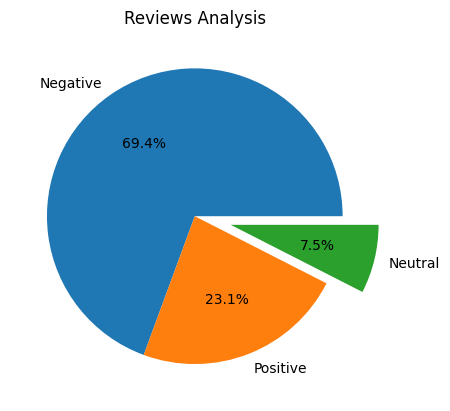

In [62]:
import matplotlib.pyplot as plt
plt.title("Reviews Analysis")
plt.pie(analysis_counts.values, labels = analysis_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.plot()

### Data Cleaning

In [66]:
import re

def clean(text):
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

df['Cleaned Reviews'] = df['reviews'].apply(clean)
df.head()

,reviews,Sentiment,Analysis,Cleaned Reviews
0,"Flight cancelled due to bad weather, BA conta...",0.596104,Positive,Flight cancelled due to bad weather BA contac...
1,British Airways oversold my LHR to LAX fligh...,-0.929386,Negative,British Airways oversold my LHR to LAX flight...
2,"I travelled London to Doha on July 16th, I h...",-0.630903,Negative,I travelled London to Doha on July th I had t...
3,When dropping off my luggage at the luggage ...,-0.665772,Negative,When dropping off my luggage at the luggage d...
4,If you can’t fly First Class don’t fly Britis...,-0.948673,Negative,If you can t fly First Class don t fly Britis...


### Nautral Language Processing

In [67]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [68]:
nltk.download('averaged_perceptron_tagger')
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))

    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))

    return newlist

df['POS tagged'] = df['Cleaned Reviews'].apply(token_stop_pos)
df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,reviews,Sentiment,Analysis,Cleaned Reviews,POS tagged
0,"Flight cancelled due to bad weather, BA conta...",0.596104,Positive,Flight cancelled due to bad weather BA contac...,"[(Flight, n), (cancelled, v), (due, a), (bad, ..."
1,British Airways oversold my LHR to LAX fligh...,-0.929386,Negative,British Airways oversold my LHR to LAX flight...,"[(British, a), (Airways, n), (oversold, None),..."
2,"I travelled London to Doha on July 16th, I h...",-0.630903,Negative,I travelled London to Doha on July th I had t...,"[(travelled, v), (London, n), (Doha, v), (July..."
3,When dropping off my luggage at the luggage ...,-0.665772,Negative,When dropping off my luggage at the luggage d...,"[(dropping, v), (luggage, n), (luggage, n), (d..."
4,If you can’t fly First Class don’t fly Britis...,-0.948673,Negative,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (..."


In [69]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['Lemma'] = df['POS tagged'].apply(lemmatize)
df.head()

,reviews,Sentiment,Analysis,Cleaned Reviews,POS tagged,Lemma
0,"Flight cancelled due to bad weather, BA conta...",0.596104,Positive,Flight cancelled due to bad weather BA contac...,"[(Flight, n), (cancelled, v), (due, a), (bad, ...",Flight cancel due bad weather BA contact ema...
1,British Airways oversold my LHR to LAX fligh...,-0.929386,Negative,British Airways oversold my LHR to LAX flight...,"[(British, a), (Airways, n), (oversold, None),...",British Airways oversold LHR LAX flight book...
2,"I travelled London to Doha on July 16th, I h...",-0.630903,Negative,I travelled London to Doha on July th I had t...,"[(travelled, v), (London, n), (Doha, v), (July...",travel London Doha July th physically check ...
3,When dropping off my luggage at the luggage ...,-0.665772,Negative,When dropping off my luggage at the luggage d...,"[(dropping, v), (luggage, n), (luggage, n), (d...",drop luggage luggage drop Toulouse airport t...
4,If you can’t fly First Class don’t fly Britis...,-0.948673,Negative,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...


### Sentimental Analysis

In [65]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment_vader'] = df['Lemma'].apply(vadersentimentanalysis)

def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'

df['Analysis_vander'] = df['Sentiment_vader'].apply(vader_analysis)


In [78]:
df.head()

,reviews,Sentiment,Analysis,Cleaned Reviews,POS tagged,Lemma,Sentiment_vader,Analysis_vander
0,"Flight cancelled due to bad weather, BA conta...",0.596104,Positive,Flight cancelled due to bad weather BA contac...,"[(Flight, n), (cancelled, v), (due, a), (bad, ...",Flight cancel due bad weather BA contact ema...,0.4215,Neutral
1,British Airways oversold my LHR to LAX fligh...,-0.929386,Negative,British Airways oversold my LHR to LAX flight...,"[(British, a), (Airways, n), (oversold, None),...",British Airways oversold LHR LAX flight book...,-0.9587,Negative
2,"I travelled London to Doha on July 16th, I h...",-0.630903,Negative,I travelled London to Doha on July th I had t...,"[(travelled, v), (London, n), (Doha, v), (July...",travel London Doha July th physically check ...,0.9456,Positive
3,When dropping off my luggage at the luggage ...,-0.665772,Negative,When dropping off my luggage at the luggage d...,"[(dropping, v), (luggage, n), (luggage, n), (d...",drop luggage luggage drop Toulouse airport t...,0.9337,Positive
4,If you can’t fly First Class don’t fly Britis...,-0.948673,Negative,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...,-0.9488,Negative


In [79]:
vader_counts = df['Analysis_vander'].value_counts()
vader_counts

,count
Analysis_vander,
Positive,1178
Negative,869
Neutral,259


[]

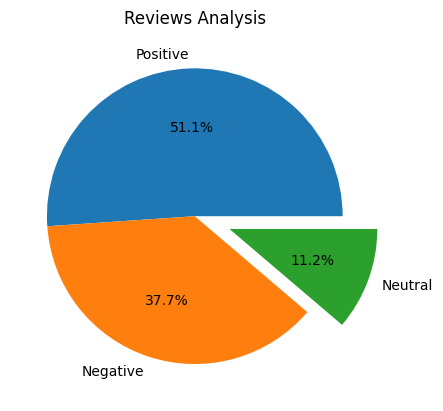

In [80]:
import matplotlib.pyplot as plt
plt.title("Reviews Analysis")
plt.pie(vader_counts.values, labels = vader_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)
plt.plot()

In [81]:
df.to_csv("BA_Sentimental_Analysis.csv")

### Comparision check between tranformers and vander sentimental analysis

In [100]:
print(df['reviews'].iloc[2])
print("Tranformer Analysis-->",df['Analysis'].iloc[2])
print("Vander Analysis-->",df['Analysis_vander'].iloc[2])

  I travelled London to Doha on July 16th, I had to physically check in at BA Business T5 because I had an ongoing connection in Doha and the flight was a code share with Qatar. I had paid for my flight through Qatar and paid for the seat online so I could sit where I like to sit and when I got to check in discovered I had been reseated elsewhere in the cabin and was told that was their policy and basically to shut up about it. I then discovered that BA do not recognise Qatar frequent flyer rules despite sharing Avios points. I'm a Gold card holder in Qatar which affords me extra kilos on the baggage but BA tried to tell me I had to pay. After some arguing eventually they accepted it! The Lounge was packed, staff less than helpful when I tried to get some answers on my seat reassignment, I was told I would get my money back - no chance of that so don't even try. The flight boarded by bus, the journey took 15 minutes to get from terminal to aircraft which I am guessing was at another te

In [99]:
print(df['reviews'].iloc[3])
print("Tranformer Analysis-->",df['Analysis'].iloc[3])
print("Vander Analysis-->",df['Analysis_vander'].iloc[3])

  When dropping off my luggage at the luggage drop off at Toulouse airport, I had my travel pram confiscated from me and I was forced to take my sleeping 2 year old in my arms while traveling alone with him at 5.30am. I was told by the staff outsourced by British Airways to check in passengers that only yoyo prams were accepted on board. I corrected her that it was "yoyo type" prams but she contested and told me that only yoyo prams would be allowed and if I insisted to keep my sleeping 2-year-old in his pram I would not be permitted to board the flight to London. This happened to 2 other families and we were forced to go to the oversized baggage area of the airport. To clarify my pram is the Silver Cross Jet stroller pushchair which I specifically purchased as it is conform to the British Airways specifications. I was then required to carry my toddler for 30 mins through security, and then again for another 40 mins while waiting to board the plane (I was "allowed" early boarding only 